# LSTM recipe generator training

Note: This notebook is desinged to run with GPU runtime.

Install Huggingface libraries to use the pretrained tokenizer and the recipe dataset.

In [1]:
pip install -q git+https://github.com/huggingface/transformers.git datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Import modules and set random seeds.

In [2]:
import os, random
os.environ['PYTHONHASHSEED'] = str(20230629)
random.seed(20240329)

import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame

import tensorflow as tf
from tensorflow.keras import layers, models

np.random.seed(20230629)
tf.random.set_seed(20230629)

plt.rcParams.update({'font.size': 10})

Download the pretrained tokenizer and check the vacabulary size.

In [3]:
from transformers import AutoTokenizer, AutoConfig
model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
VOCAB_SIZE = AutoConfig.from_pretrained(model_ckpt).vocab_size

print('Vocabulary size: {}'.format(VOCAB_SIZE))

Vocabulary size: 30522


Download the recipe dataset and extract directions texts.

In [4]:
from datasets import load_dataset
recipe = load_dataset('Shengtao/recipe')

def join_title_and_directions(title_directions):
    title, directions = title_directions
    return 'Recipe for {}: {}'.format(title, directions)

recipe_texts = list(map(join_title_and_directions,
                        zip(recipe['train']['title'], recipe['train']['directions'])))
recipe_texts = recipe_texts[::4] # Select 25% of the entire training set.

  0%|          | 0/1 [00:00<?, ?it/s]

Check the distribuion of the text length.

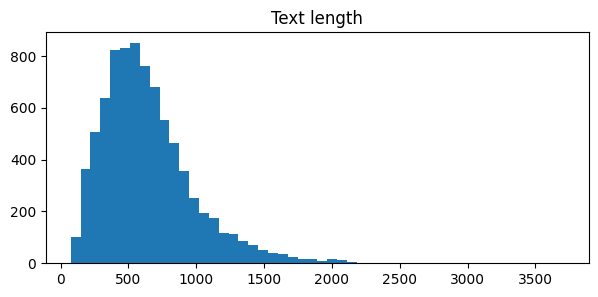

In [5]:
fig = plt.figure(figsize=(7, 3))
subplot = fig.add_subplot(1,1,1)
subplot.set_title('Text length')
_ = subplot.hist(list(map(lambda x: len(x), recipe_texts)), bins=50)

Create the training and test datasets, truncating long texts into 512 words.

In [6]:
MAX_LEN = 512
train_set = tokenizer(recipe_texts, max_length=MAX_LEN,
                      padding='max_length', truncation=True)

train_text = np.array(train_set['input_ids'])[:, :-1]
train_label = np.array(train_set['input_ids'])[:, 1:]

Define the LSTM model.

In [7]:
lstm_model = models.Sequential(name='LSTM_next_word_predictor')
lstm_model.add(layers.Embedding(VOCAB_SIZE, 512, input_shape=(None,), name='text_embedding'))
lstm_model.add(layers.LSTM(512, return_sequences=True, name='LSTM_cell'))
lstm_model.add(layers.Dense(VOCAB_SIZE, activation='softmax', name='softmax'))

lstm_model.summary()

Model: "LSTM_next_word_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_embedding (Embedding)  (None, None, 512)         15627264  
                                                                 
 LSTM_cell (LSTM)            (None, None, 512)         2099200   
                                                                 
 softmax (Dense)             (None, None, 30522)       15657786  
                                                                 
Total params: 33,384,250
Trainable params: 33,384,250
Non-trainable params: 0
_________________________________________________________________


Compile the model using the Adam optimizer, and the sparse categorical crossentroy as a loss function.

In [8]:
lstm_model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['acc'])

Train the model.

In [9]:
%%time
history = lstm_model.fit(train_text, train_label,
                         batch_size=8, epochs=5)

Epoch 1/5
1023/1023 [==============================] - 290s 274ms/step - loss: 1.4940 - acc: 0.7683
Epoch 2/5
1023/1023 [==============================] - 239s 233ms/step - loss: 0.7943 - acc: 0.8426
Epoch 3/5
1023/1023 [==============================] - 236s 231ms/step - loss: 0.6844 - acc: 0.8562
Epoch 4/5
1023/1023 [==============================] - 235s 230ms/step - loss: 0.6300 - acc: 0.8632
Epoch 5/5
1023/1023 [==============================] - 234s 229ms/step - loss: 0.5924 - acc: 0.8680
CPU times: user 8min 42s, sys: 3min 7s, total: 11min 49s
Wall time: 21min 26s


Mount the google drive and save the trained model.

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

lstm_model.save('/content/gdrive/My Drive/LSTM_recipe_generator.hd5', save_format='h5')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [11]:
ls -lh '/content/gdrive/My Drive/LSTM_recipe_generator.hd5'

-rw------- 1 root root 383M Jul 10 11:27 '/content/gdrive/My Drive/LSTM_recipe_generator.hd5'
